# EM casing response

In [1]:
import numpy as np
import scipy.sparse as sp
from scipy.constants import mu_0
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, LinearSegmentedColormap
import time
from string import ascii_lowercase

# SimPEG, discretize/
import discretize
from discretize import utils
from SimPEG.electromagnetics import time_domain as tdem
from SimPEG import utils, maps, Report
from pymatsolver import Pardiso

# casing utility code 
import casingSimulations as casing_sim

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
from matplotlib import rcParams
rcParams["font.size"] = 12

In [4]:
# conductivities
sigma_air = 1e-6
sigma_back = 1e-2
sigma_casing = 5e6
sigma_target = 1e-1
sigma_target_resistive = 1e-3
mur_casing = 100

# target geometry
target_r = 200
target_z = np.r_[-950, -850]

# casing geometry
casing_b = 5e-2  
casing_t = 10e-3
casing_a = casing_b - casing_t
casing_l = 1000

In [5]:
sigma_back * (900 / 1260)**2 * 1e3

5.102040816326531

In [6]:
return_electrode_r = 1000
src_a = np.r_[casing_a+casing_t/2, 0, 0]
src_b = np.r_[return_electrode_r, 0., 0.]

In [7]:
csz = 5
npadz = 13
pf = 1.5

meshes = {}

hx = casing_sim.mesh.pad_for_casing_and_data(
    casing_b,
    csx1=casing_t/4., 
    npadx=7,
    csx2=100,
    domain_x=return_electrode_r
)

# Theta discretization
ny = 12
hy = np.ones(12)
hy = hy*2*np.pi / hy.sum()

# vertical discretization
ncz = casing_l/csz
hz = discretize.utils.unpack_widths([(csz, npadz, -pf), (csz, ncz), (csz, npadz, pf)])

# create the mesh
mesh = discretize.CylindricalMesh([hx, hy, hz], x0=np.r_[0,0,-hz[:-npadz].sum()])
print(mesh.n_cells)

214248


In [8]:
nt = 30
time_steps = [
    (1e-6, nt), (3e-6, nt), 
    (1e-5, nt), (3e-5, nt), 
    (1e-4, nt), (3e-4, nt), 
    (1e-3, nt), (3e-3, nt)
]

time_steps = discretize.utils.unpack_widths(time_steps)
times = np.cumsum(np.hstack([np.r_[0], time_steps]))
print(times.max()*1e3)

print(f"diffusion distance {np.sqrt(2*np.max(times)/(mu_0*sigma_back)):1.0f} m")

133.32000000000008
diffusion distance 4606 m


[<PolarAxesSubplot:>, <AxesSubplot:xlabel='x', ylabel='z'>]

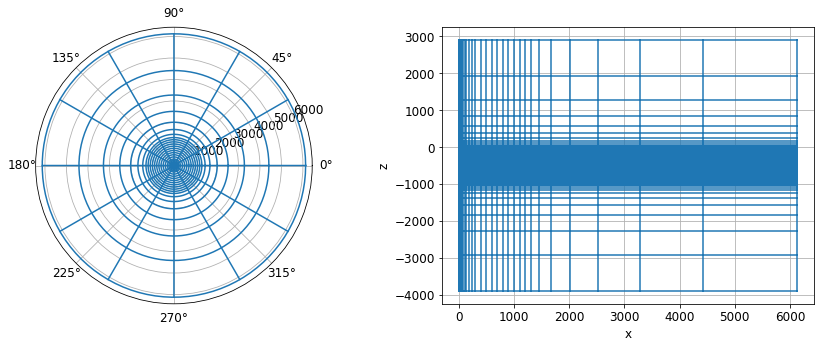

In [9]:
mesh.plot_grid()

In [10]:
inds_casing_x = (
    (mesh.cell_centers[:, 0] > casing_a) & 
    (mesh.cell_centers[:, 0] < casing_b)
)
inds_casing_z = (
    (mesh.cell_centers[:, 2] < 0) &
    (mesh.cell_centers[:, 2] > -casing_l)
)
inds_casing = inds_casing_x & inds_casing_z


inds_target_x = (
    (mesh.cell_centers[:, 0] >= casing_b) &
    (mesh.cell_centers[:, 0] < target_r)
)
inds_target_z = (
    (mesh.cell_centers[:, 2] < target_z.max()) &
    (mesh.cell_centers[:, 2] > target_z.min())
)
inds_target = inds_target_x & inds_target_z

In [11]:
halfspace = sigma_back * np.ones(mesh.n_cells)
halfspace[mesh.cell_centers[:, 2] > 0] = sigma_air

halfspace_target = halfspace.copy()
halfspace_target_resistive = halfspace.copy()

halfspace_target[inds_target] = sigma_target
halfspace_target_resistive[inds_target] = sigma_target_resistive

casing = halfspace.copy()
casing[inds_casing] = sigma_casing

casing_target = halfspace_target.copy()
casing_target[inds_casing] = sigma_casing

casing_target_resistive = halfspace_target_resistive.copy()
casing_target_resistive[inds_casing] = sigma_casing

models = {
    "halfspace" : halfspace,
    "halfspace_target" : halfspace_target,
    "halfspace_target_resistive" : halfspace_target_resistive,
    "casing" : casing,
    "casing_target" : casing_target,
    "casing_target_resistive" : casing_target_resistive,
    "casing_permeable": casing, 
    "casing_permeable_target": casing_target,
    "casing_permeable_target_resistive": casing_target_resistive,
}

casing_mur = np.ones(mesh.n_cells)
casing_mur[inds_casing] = mur_casing

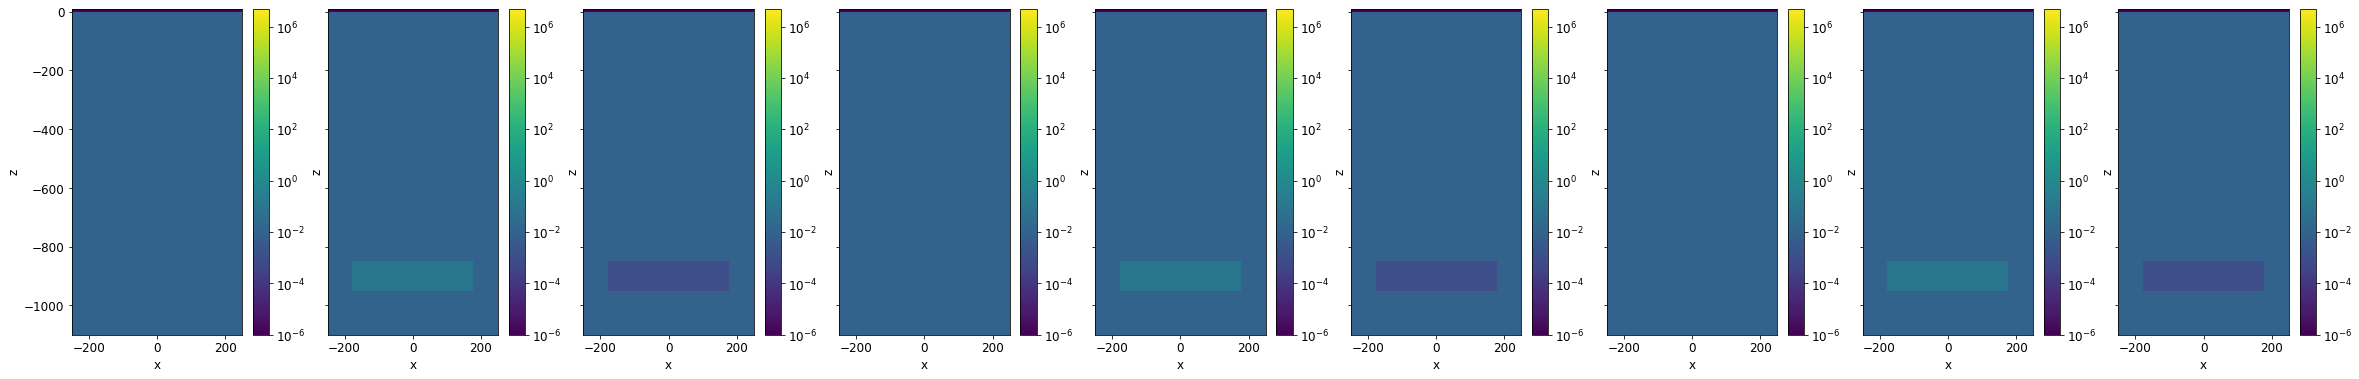

In [12]:
fig, ax = plt.subplots(1, len(models), figsize=(4.5*len(models), 6), sharex=True, sharey=True)

pcolor_opts={"norm":LogNorm(vmin=sigma_air, vmax=sigma_casing)}
for i, key in enumerate(models.keys()):
    casing_sim.view.plot_slice(
        mesh, models[key], pcolorOpts=pcolor_opts, ax=ax[i],
    )
    
    ax[i].set_xlim((target_r+50)*np.r_[-1, 1])
    ax[i].set_ylim(np.r_[-casing_l-100, 10])


## set up the simulations

In [13]:
# top casing source 
src_theta = np.pi / 2. + mesh.hy[0]/2.
src_a = np.r_[casing_b - mesh.hx.min()/2, src_theta, -csz]
src_b = np.r_[return_electrode_r, src_theta, -csz]
src_locations = np.vstack(
    [
        src_a, src_a+np.r_[0, 0, csz*1.5], src_b+np.r_[0, 0, csz*1.5], src_b
    ]
)

In [14]:
src = tdem.sources.LineCurrent([], location=src_locations)
survey = tdem.Survey([src])
sim = tdem.simulation.Simulation3DCurrentDensity(
    mesh=mesh, sigmaMap=maps.IdentityMap(mesh),
    survey=survey, solver=Pardiso, time_steps=time_steps, 
#     verbose=True
)


In [15]:
fields = {}
for key, m in models.items():
    t = time.time()
    print(f"starting {key}")
    if "permeable" in key:
        sim.mu = mu_0 * casing_mur
    fields[key] = sim.fields(m)
    print(f" ... done. {time.time()-t:1.2e} s")

starting halfspace
 ... done. 3.25e+02 s
starting halfspace_target
 ... done. 2.10e+02 s
starting halfspace_target_resistive
 ... done. 2.10e+02 s
starting casing
 ... done. 2.13e+02 s
starting casing_target
 ... done. 2.03e+02 s
starting casing_target_resistive
 ... done. 2.10e+02 s
starting casing_permeable
 ... done. 2.12e+02 s
starting casing_permeable_target
 ... done. 2.11e+02 s
starting casing_permeable_target_resistive
 ... done. 2.01e+02 s


In [16]:
time_inds = [
    0,
#     1, 
#     3, 
#     10, 
#     30, 
    53, 
#     78, 
    109,
    # 137,
    152,
    169,
#     197,
#     229
] 
times[time_inds] * 1e3

array([ 0.   ,  0.099,  0.99 ,  4.92 , 10.02 ])

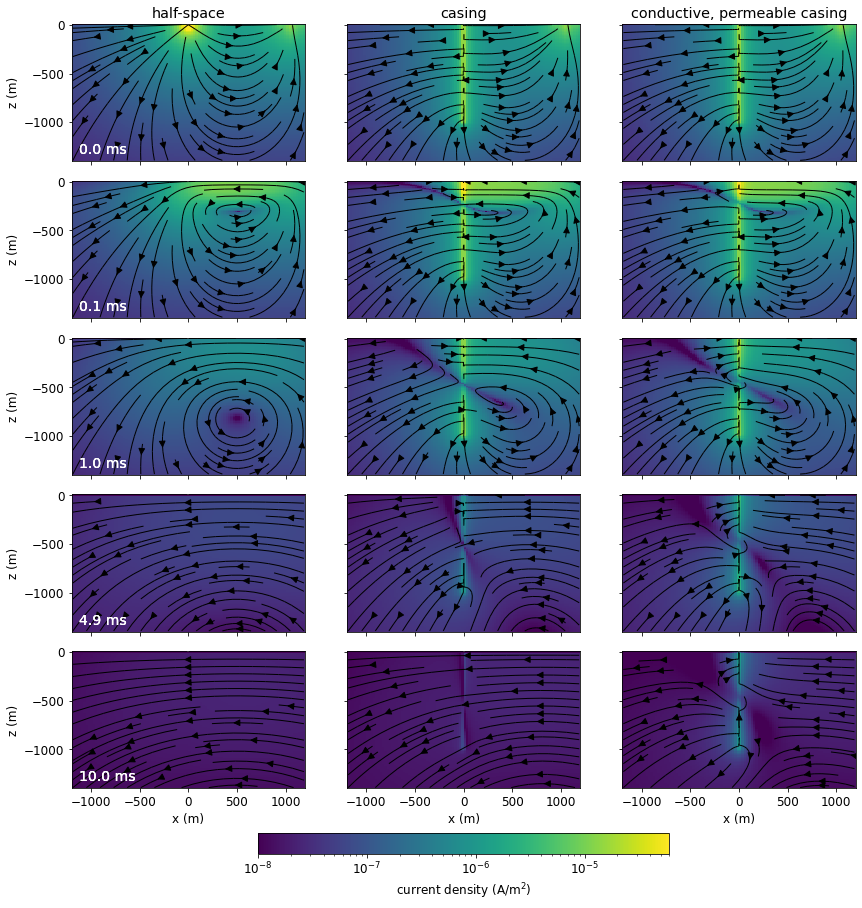

In [17]:
fig, ax = plt.subplots(
    len(time_inds), 3, 
    figsize=(12, len(time_inds)*2.5),
    constrained_layout=True,
    sharex=True, sharey=True, 
    gridspec_kw={"hspace":0.07,"wspace":0.1}
)

xlim=np.r_[-1200, 1200]
zlim=np.r_[-1400, 10]
clim = np.r_[1e-8, 6e-5]

stream_opts={"color":"k", "density":0.6, "arrowsize":1.4, "linewidth":1}


for j, key in enumerate(["halfspace", "casing", "casing_permeable"]):
    f = fields[key]
    ax[0, j].set_title("")
    
    for i, ti in enumerate(time_inds): 
        out = casing_sim.view.plot_cross_section(
            f,
            view="j",
            time_ind=ti,
            xlim=xlim,
            zlim=zlim,
            theta_ind=3,
            ax=ax[i,j], 
            clim=clim,
            show_cb=False if j<3 else True,
            stream_opts=stream_opts
        )
        ax[i, j].plot(np.r_[0, 0], np.r_[0, return_electrode_r], "w--")
        ax[i, j].set_title("")
        ax[i, 0].text(xlim.min()+75, zlim.min()+75, f"{times[ti]*1e3:1.1f} ms", color="w", fontsize=14)
        if i < len(time_inds)-1:
            ax[i, j].set_xlabel("")
        else:
            ax[i, j].set_xlabel("x (m)")
        if j > 0: 
            ax[i, j].set_ylabel("")
        else:
            ax[i, j].set_ylabel("z (m)")
        ax[i, j].set_aspect(1)

ax[0, 0].set_title("half-space")
ax[0, 1].set_title("casing")
ax[0, 2].set_title("conductive, permeable casing")

cb = plt.colorbar(out[0], ax=ax[-1, :], orientation="horizontal", shrink=0.6)
cb.set_label("current density (A/m$^2$)")

# fig.savefig("figures/tdem-currents-cross-section-permeable", dpi=200, bbox_inches="tight")

Text(0.5, 1.0, '(d) anomalous currents, resistive target')

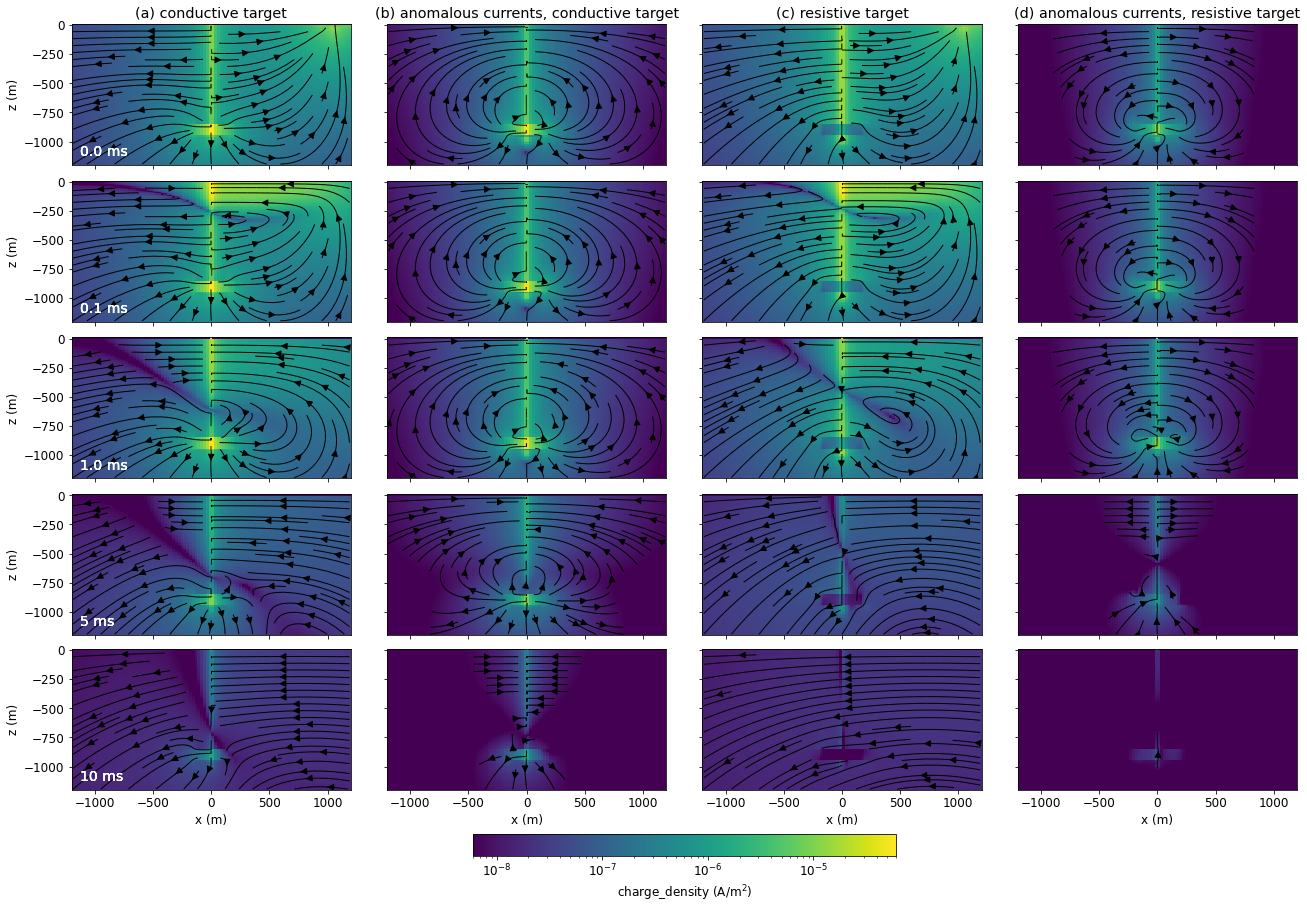

In [18]:
fig, ax = plt.subplots(
    len(time_inds), 4, 
    figsize=(18, len(time_inds)*2.5),
    constrained_layout=True,
    sharex=True, sharey=True, 
    gridspec_kw={"hspace":0.07,"wspace":0.1}
)

xlim=np.r_[-1200, 1200]
zlim=np.r_[-1200, 10]
clim = np.r_[6e-9, 6e-5]

stream_opts={"color":"k", "density":0.7, "arrowsize":1.4, "linewidth":1}

k=0
for j, key in enumerate(["casing_target", "casing_target_resistive"]):
    f = fields[key]
    
    for primsec in ["total", "secondary"]:
    
        ax[0, k].set_title("")

        for i, ti in enumerate(time_inds): 
            out = casing_sim.view.plot_cross_section(
                f,
                view="j",
                primary_fields=fields["casing"],
                prim_sec=primsec,
                time_ind=ti,
                xlim=xlim,
                zlim=zlim,
                theta_ind=3,
                ax=ax[i,k], 
                clim=clim,
                show_cb=False,
                stream_opts=stream_opts
            )
            ax[i, k].plot(np.r_[0, 0], np.r_[0, return_electrode_r], "w--")
            ax[i, k].set_title("")
            ax[i, 0].text(
                xlim.min()+75, zlim.min()+75, 
                f"{times[ti]*1e3:1.1f} ms" if times[ti]*1e3 < 1 else f"{times[ti]*1e3:1.0f} ms", 
                color="w", fontsize=14
            )
            if i < len(time_inds)-1:
                ax[i, k].set_xlabel("")
            else:
                ax[i, k].set_xlabel("x (m)")
            if k > 0: 
                ax[i, k].set_ylabel("")
            else:
                ax[i, k].set_ylabel("z (m)")
            ax[i, k].set_aspect(1)
        k += 1

cb = plt.colorbar(out[0], ax=ax[-1, :], orientation="horizontal", shrink=0.6)
cb.set_label("charge_density (A/m$^2$)")

ax[0, 0].set_title("(a) conductive target")
ax[0, 1].set_title("(b) anomalous currents, conductive target")
ax[0, 2].set_title("(c) resistive target")
ax[0, 3].set_title("(d) anomalous currents, resistive target")

# fig.savefig("figures/tdem-currents-cross-section-target", dpi=200, bbox_inches="tight")
# fig.savefig("high-rez-figures/tdem-currents-cross-section-target", dpi=350, bbox_inches="tight")

Text(0.5, 1.0, '(d)')

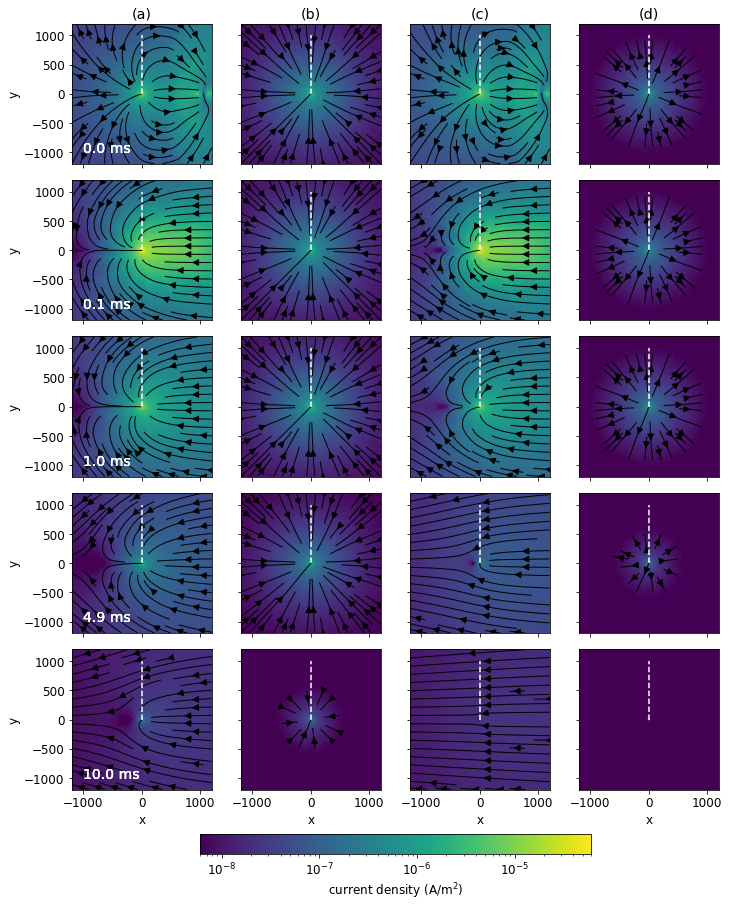

In [19]:
fig, ax = plt.subplots(
    len(time_inds), 4, 
    figsize=(10, len(time_inds)*2.5),
    constrained_layout=True,
    sharex=True, sharey=True, 
    gridspec_kw={"hspace":0.07,"wspace":0.1}
)

xlim=np.r_[-1200, 1200]
zlim=np.r_[-1400, 10]
clim = np.r_[6e-9, 6e-5]

stream_opts={"color":"k", "density":0.6, "arrowsize":1.4, "linewidth":1}
z_loc = -csz/2
k=0
for j, key in enumerate(["casing_target", "casing_target_resistive"]):
    f = fields[key]

    for primsec in ["total", "secondary"]:

        for i, ti in enumerate(time_inds):  
            f = fields[key]
            zind = np.where(f.mesh.cell_centers_z == z_loc)[0][0]
            ax[0, j].set_title("")

            casing_sim.view.plot_depth_slice(
                f,
                view="j",
                primary_fields=fields["casing"],
                prim_sec=primsec,
                time_ind=ti,
                xlim=xlim,
                ylim=xlim,
                z_ind=zind, 
                k=15,
                theta_shift=hy[0]/2.,
                rotate=True,
                ax=ax[i,k], 
                clim=clim,
                show_cb=False,
                stream_opts=stream_opts,
            )
            ax[i, k].plot(np.r_[0, 0], np.r_[0, return_electrode_r], "w--")
            ax[i, k].set_title("")
            ax[i, 0].text(-1000, -1000, f"{times[ti]*1e3:1.1f} ms", color="w", fontsize=14)
            if i < len(time_inds)-1:
                ax[i, k].set_xlabel("")
            if k > 0: 
                ax[i, k].set_ylabel("")
            ax[i, k].set_aspect(1)
        k += 1

    # ax[0, k].set_title(key)

cb = plt.colorbar(out[0], ax=ax[-1, :], orientation="horizontal", shrink=0.6)
cb.set_label("current density (A/m$^2$)")

ax[0, 0].set_title("(a)")
ax[0, 1].set_title("(b)")
ax[0, 2].set_title("(c)")
ax[0, 3].set_title("(d)")
# fig.savefig("figures/tdem-currents-depth-slice-target", dpi=200, bbox_inches="tight")

In [20]:
plot_spatial = {}

for model_type in ["halfspace", "casing", "casing_permeable"]:
    tmp = {}
    for ti in time_inds:
        primary = discretize.utils.mkvc(fields[f"{model_type}"][:,'e', ti])
        target = discretize.utils.mkvc(fields[f"{model_type}_target"][:,'e', ti])
        tmp[ti] = {
            "target":target, 
            "primary":primary,
            "difference":target - primary,
            "percent":(target - primary)/primary * 100
        }
    plot_spatial[model_type] = tmp

In [21]:
from matplotlib import patches

Text(8.96, 0.5, 'electric field amplitude (V/m)')

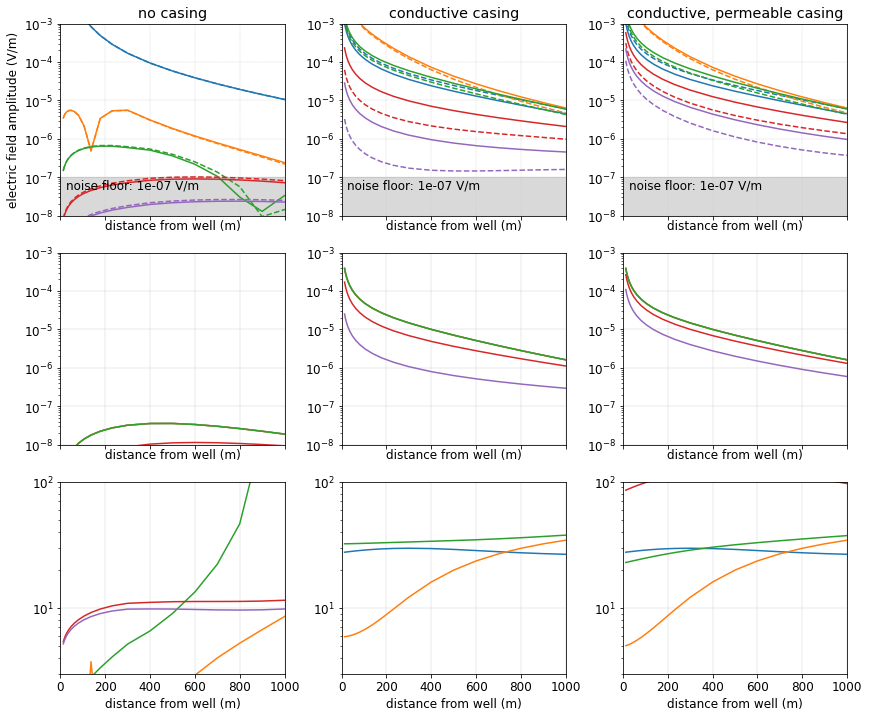

In [22]:
fig, ax = plt.subplots(3, 3, figsize=(12, 10), sharex=True, sharey=False)
ti = time_inds[-1] #0
xlim = np.r_[10, 1200]
ylim = np.r_[1e-8, 1e-3]
noise_floor = 1e-7

for j, ti in enumerate(time_inds):
    for i, model_type in enumerate(["halfspace", "casing", "casing_permeable"]):
        tmp = plot_spatial[model_type][ti]
        for label, a in zip(
            tmp.keys(),
            [ax[0, i], ax[0, i], ax[1, i], ax[2, i]]
        ):
            f = tmp[label]
            casing_sim.view.plotLinesFx(
                mesh,
                field=np.absolute(f),
                pltType="semilogy", 
                ax=a, 
                theta_ind=0,
                xlim=xlim,
                color=f"C{j}", label=label, linestyle="--" if label == "primary" else "-",
            )
#         ax[0, i].legend(loc=1)
        ax[0, i].set_xlim(np.r_[0, 1000])
        ax[0, i].set_ylim(ylim)
        ax[1, i].set_ylim(ylim)
        ax[2, i].set_ylim(3, 1e2)
    
        if j == 0:
            patch = patches.Rectangle(
                [0, 1e-9], xlim[1], noise_floor, color='k', alpha=0.15
            )
            ax[0, i].add_patch(patch)
            ax[0, i].text(xlim[0]+15, noise_floor*0.9, f"noise floor: {noise_floor:1.0e} V/m", va="top", fontsize=12)

ax[0, 0].set_title("no casing")
ax[0, 1].set_title("conductive casing")
ax[0, 2].set_title("conductive, permeable casing")
ax[0, 0].set_ylabel("electric field amplitude (V/m)")

In [23]:
xlocs = np.r_[62, 64, 66]
mesh.vectorNx[xlocs]

array([300., 500., 700.])

In [24]:
zloc = -csz/2
theta_loc = 0

face_inds = np.zeros_like(xlocs)

for i, xl in enumerate(xlocs):
    face_inds[i] = np.where(
        (mesh.faces_x[:, 0] == mesh.vectorNx[xl]) &
        (mesh.faces_x[:, 1] == mesh.vectorCCy[theta_loc]) & 
        (mesh.faces_x[:, 2] == zloc)
    )[0]
    print(mesh.faces_x[face_inds[i], :])

[ 3.00000000e+02  2.61799388e-01 -2.50000000e+00]
[ 5.00000000e+02  2.61799388e-01 -2.50000000e+00]
[ 7.00000000e+02  2.61799388e-01 -2.50000000e+00]


In [25]:
plot_timeseries = {}

for model_type in ["halfspace", "casing", "casing_permeable"]:
    tmp = {}
    for fi in face_inds:
        primary = np.abs(discretize.utils.mkvc(fields[f"{model_type}"][:,'e', :][fi, :]))
        target = np.abs(discretize.utils.mkvc(fields[f"{model_type}_target"][:,'e', :][fi, :]))
        tmp[fi] = {
            "target":target, 
            "primary":primary,
            "difference":target - primary,
            "percent":(target - primary)/np.abs(primary) * 100
        }
    plot_timeseries[model_type] = tmp

In [26]:
plot_timeseries_resistive = {}

for model_type in ["halfspace", "casing", "casing_permeable"]:
    tmp = {}
    for fi in face_inds:
        primary = np.abs(discretize.utils.mkvc(fields[f"{model_type}"][:,'e', :][fi, :]))
        target = np.abs(discretize.utils.mkvc(fields[f"{model_type}_target_resistive"][:,'e', :][fi, :]))
        tmp[fi] = {
            "target":target, 
            "primary":primary,
            "difference":target - primary,
            "percent":(target - primary)/np.abs(primary) * 100
        }
    plot_timeseries_resistive[model_type] = tmp

In [32]:
def plot_data_dict(data_dict, logy=True, xlim0=np.r_[0, 0.002], symbol_legend="positive"):
    fig, ax = plt.subplots(
    3, 5, figsize=(14, 11),
    gridspec_kw={
        'width_ratios': [0.5, 3.5, 0.25, 0.5, 3.5],
        "hspace":0.08, "wspace":0.1
    },
)

    for a in ax[:, 2]:
        a.axis('off')

    ax = np.hstack([ax[:, :2], ax[:, 3:]])

    # ti = time_inds[-1] #0
    xlim1 = np.r_[0, 20]
    ylim = np.r_[3e-8, 3e-4]
    noise_floor = 1e-7

    nscenarios = len(list(data_dict.keys())[1:])

    for j, fi in enumerate(face_inds):
        for i, model_type in enumerate(list(data_dict.keys())[1:]):
            tmp = data_dict[model_type][fi]
            k = i*nscenarios
            for label, a0, a1 in zip(
                tmp.keys(),
                [ax[0, k], ax[0, k], ax[1, k], ax[2, k]],
                [ax[0, k+1], ax[0, k+1], ax[1, k+1], ax[2, k+1]]
            ):
                f = tmp[label]

                for a in [a0, a1]:
                    
                    if logy is True: 
                        pos = (f >= 0) & (times*1e3 <= xlim1[-1]*2)
                        neg = (~pos) & (times*1e3 <= xlim1[-1]*2)

                        # positive
                        a.semilogy(
                            times[pos]*1e3, np.abs(f[pos]), 
                            color=f"C{j}",  linestyle="--" if label == "primary" else "-", 
                            marker="o" if a==a0 else None,
                            ms=6, 
                            label = f"{mesh.faces_x[fi, 0]: 1.0f} m" if label == "target" else None
                        )
                        
                        # negative
                        a.semilogy(
                            times[neg]*1e3, np.abs(f[neg]), 
                            color=f"C{j}",  linestyle= "-.", 
                            marker="s" if a==a0 else None,
                            ms=6, 
                        )
                        
                        if label == "percent": 
                            a.set_ylim(np.r_[1, 1e3])
                        else:
                            a.set_ylim(ylim)
                        
                    else: 
                        a.plot(
                            times*1e3, f, 
                            color=f"C{j}",  linestyle="--" if label == "primary" else "-", 
                            label = f"{mesh.faces_x[fi, 0]: 1.0f} m" if label == "target" else None
                        )
                        if label == "percent": 
                            a.set_ylim(np.r_[-200, 200])
                        # else:
                        #     a.set_ylim(ylim)
                
                a0.set_xlim(xlim0 + np.r_[-2e-4, 0])
                a1.set_xlim(xlim1)
                a1.set_xticks([0, 5, 10, 15, 20])
                a1.set_yticklabels("")
                
            if j == 0:
                for jj in [0, 1]:
                    if logy is True: 
                        ax[jj, k].add_patch(
                            patches.Rectangle(
                            [-3e-4, 1e-9], xlim0[1]*2, noise_floor, color='k', alpha=0.15
                        ))
                        ax[jj, k+1].add_patch(patches.Rectangle(
                            [0, 1e-9], xlim1[1]*2, noise_floor, color='k', alpha=0.15
                        ))
                        ax[jj, k+1].text(0.5, noise_floor*0.9, f"noise floor: {noise_floor:1.0e} V/m", va="top", fontsize=12)
                    ax[jj, k].set_xticklabels("")
                    ax[jj, k+1].set_xticklabels("")
                ax[2, k].set_xticklabels((ax[2, k].get_xticks()*1e3).astype(int))


           

            

            for a in ax.flatten():
                a.grid("both", alpha=0.5)

    ax[0, 1].legend()
    ghost_ax = ax[0, 1].twinx()
    ghost_ax.plot(
        np.NaN, np.NaN, "k-", label="target"
    )
    ghost_ax.plot(
        np.NaN, np.NaN, "k--", label="background"
    )
    ghost_ax.get_yaxis().set_visible(False)
    ghost_ax.legend(loc=5)
    
    
    ghost_ax2 = ax[1, 1].twinx()
    if symbol_legend == "positive":
        ghost_ax2.plot(
            np.NaN, np.NaN, "ko", label="positive"
        )
        ghost_ax2.plot(
            np.NaN, np.NaN, "k-.",  label="negative"
        )
    elif symbol_legend == "negative":
        ghost_ax2.plot(
            np.NaN, np.NaN, "k-", label="positive"
        )
        ghost_ax2.plot(
            np.NaN, np.NaN, "ks",  label="negative"
        )
    else:
        ghost_ax2.plot(
            np.NaN, np.NaN, "k-", label="positive"
        )
        ghost_ax2.plot(
            np.NaN, np.NaN, "k-.",  label="negative"
        )
    ghost_ax2.get_yaxis().set_visible(False)
    ghost_ax2.legend()
    
    # ghost_ax3 = ax[1, 0].twinx()
    # ghost_ax3.plot(
    #     np.NaN, np.NaN, "k-", marker="o", ms=6, label="+"
    # )
    # ghost_ax3.plot(
    #     np.NaN, np.NaN, "k-.", marker="s", ms=6, label="-"
    # )
    # ghost_ax3.get_yaxis().set_visible(False)
    # ghost_ax3.legend()

    ax[0, 0].set_ylabel("electric field amplitude (V/m)")
    ax[1, 0].set_ylabel("amplitude difference (V/m)")
    ax[2, 0].set_ylabel("amplitude difference (%)")

    ax[2, 0].set_xlabel("time ($\mu$s)")
    ax[2, 2].set_xlabel("time ($\mu$s)")

    ax[2, 1].set_xlabel("time (ms)")
    ax[2, 3].set_xlabel("time (ms)")
    
    return fig, ax

Text(0.0, 1.0, '(b) conductive target with conductive, permeable casing')

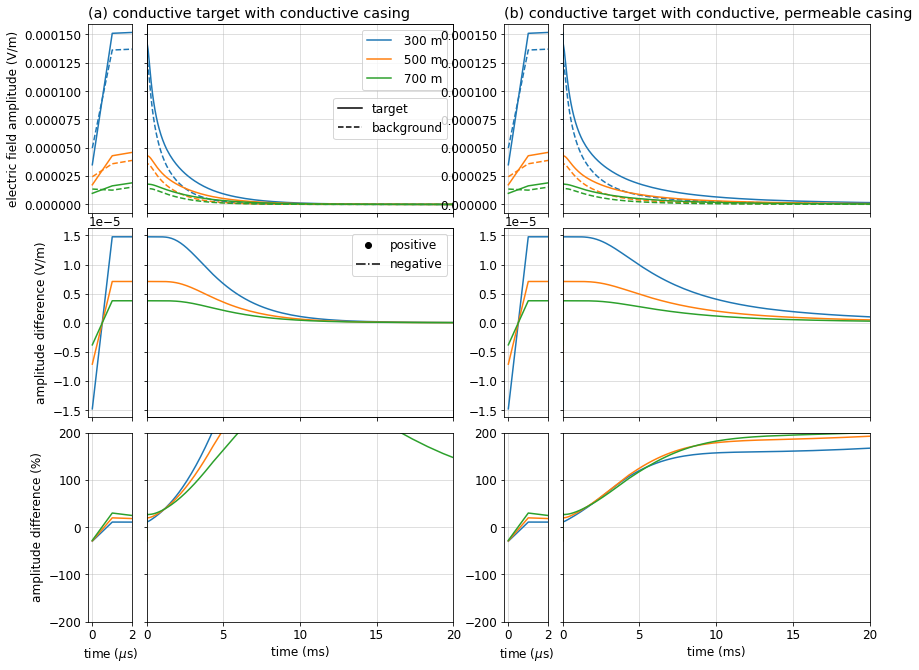

In [33]:
fig, ax = plot_data_dict(plot_timeseries, logy=False)


ax[0, 0].set_title("(a) conductive target with conductive casing", loc="left")
ax[0, 2].set_title("(b) conductive target with conductive, permeable casing", loc="left")

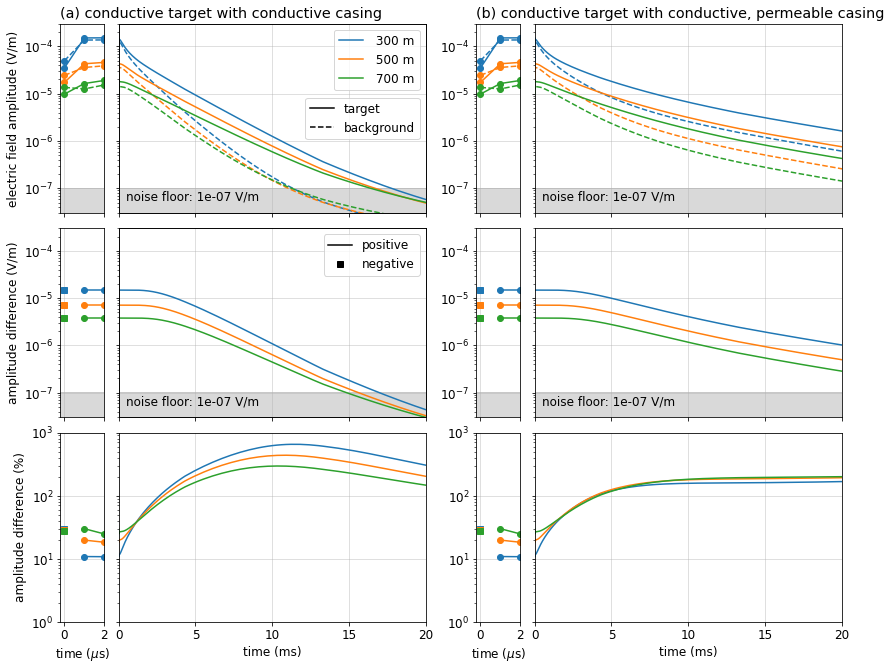

In [34]:
fig, ax = plot_data_dict(plot_timeseries, logy=True, symbol_legend="negative")


ax[0, 0].set_title("(a) conductive target with conductive casing", loc="left")
ax[0, 2].set_title("(b) conductive target with conductive, permeable casing", loc="left")
# ax[0, 1].set_title("(b) conductive casing
fig.savefig("figures/impact-of-wells-em-data.png", bbox_inches="tight", dpi=200)
fig.savefig("high-rez-figures/impact-of-wells-em-data.png", bbox_inches="tight", dpi=350)

Text(0.0, 1.0, '(b) resistive target with conductive, permeable casing')

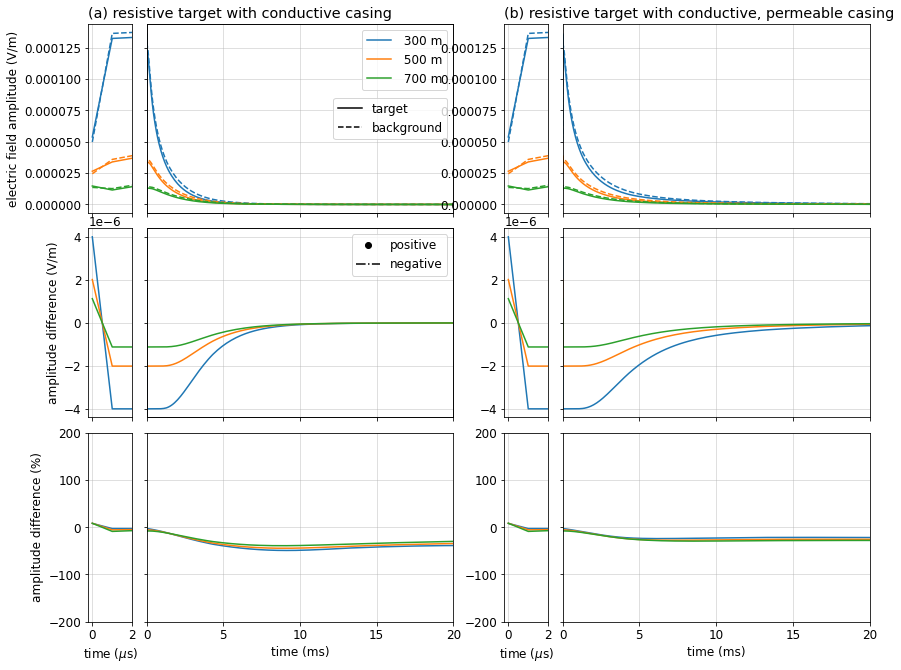

In [35]:
fig, ax = plot_data_dict(plot_timeseries_resistive, logy=False)

ax[0, 0].set_title("(a) resistive target with conductive casing", loc="left")
ax[0, 2].set_title("(b) resistive target with conductive, permeable casing", loc="left")

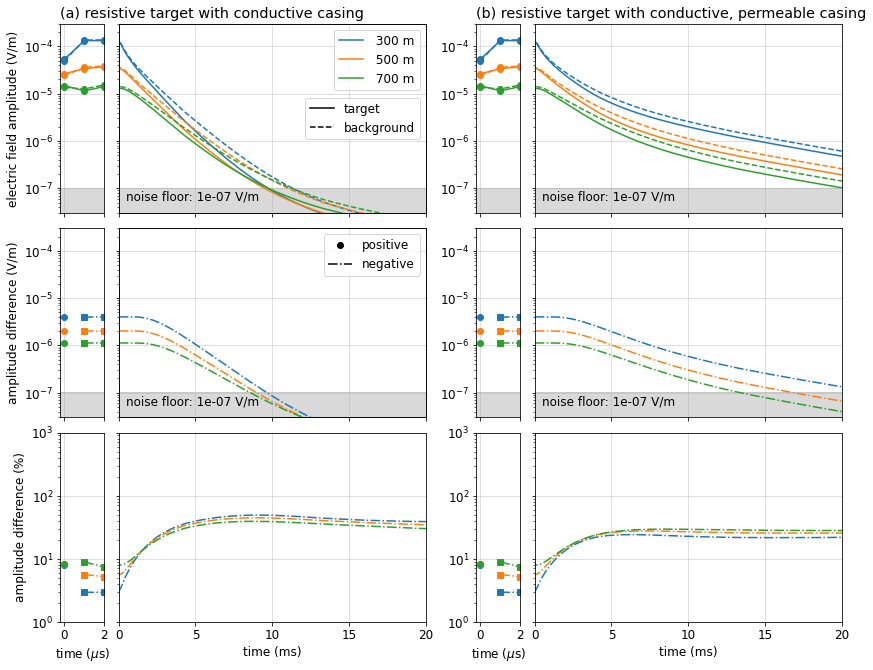

In [36]:
fig, ax = plot_data_dict(plot_timeseries_resistive, logy=True, symbol_legend="positive")

ax[0, 0].set_title("(a) resistive target with conductive casing", loc="left")
ax[0, 2].set_title("(b) resistive target with conductive, permeable casing", loc="left")
fig.savefig("figures/impact-of-wells-em-data-resistive.png", bbox_inches="tight", dpi=200)
fig.savefig("high-rez-figures/impact-of-wells-em-data-resistive.png", bbox_inches="tight", dpi=350)